<a href="https://colab.research.google.com/github/liveness-detection-bangkit-team/liveness_ai/blob/main/MobilenetV2_antispoof_ariel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
#directory = "/content/drive/MyDrive/Learning/Bootcamp/Bangkit/Machine Learning/Liveness Detection/datasets/pictures/liveness/blink"
directory = "./anti-spoof"

In [ ]:
#DATA_URL = "/content/drive/MyDrive/Learning/Bootcamp/Bangkit/Machine Learning/Liveness Detection/datasets/pictures/anti-spoof-model-dataset.zip"

In [ ]:
!unzip /content/drive/MyDrive/Learning/Bootcamp/Bangkit/Machine_Learning/Liveness_Detection/datasets/pictures/anti-spoof-model-dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/attack/0008_00_00_01_233.jpg  
  inflating: /content/attack/0008_00_00_01_471.jpg  
  inflating: /content/attack/0008_00_00_01_79.jpg  
  inflating: /content/attack/0008_00_00_01_435.jpg  
  inflating: /content/attack/0008_00_00_01_200.jpg  
  inflating: /content/attack/0008_00_00_01_163.jpg  
  inflating: /content/attack/0008_00_00_01_412.jpg  
  inflating: /content/attack/0008_00_00_01_367.jpg  
  inflating: /content/attack/0008_00_00_01_196.jpg  
  inflating: /content/attack/0008_00_00_01_352.jpg  
  inflating: /content/attack/0008_00_00_01_159.jpg  
  inflating: /content/attack/0008_00_00_01_387.jpg  
  inflating: /content/attack/0008_00_00_01_15.jpg  
  inflating: /content/attack/0008_00_00_01_444.jpg  
  inflating: /content/attack/0008_00_00_01_392.jpg  
  inflating: /content/attack/0008_00_00_01_145.jpg  
  inflating: /content/attack/0008_00_00_01_324.jpg  
  inflating: /content/attack/0008_00_00_01_127.jpg

In [ ]:
#data_root_origin = tf.keras.utils.get_file('anti-spoof-model-dataset.zip', origin=DATA_URL, extract=True)
#data_root = pathlib.Path(data_root_orig)

In [ ]:
seed_init = 45
IMAGE_SIZE = (224, 224)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    seed = seed_init,
    directory= directory,
    batch_size= 32,
    image_size= IMAGE_SIZE,
    shuffle = True,
    subset = 'training',
    validation_split = 0.2,
    label_mode= 'binary',
)


validation_dataset = tf.keras.utils.image_dataset_from_directory(
    seed = seed_init,
    directory= directory,
    batch_size= 32,
    image_size= IMAGE_SIZE,
    shuffle = True,
    subset= 'validation',
    validation_split = 0.2,
		label_mode= 'binary',
)


Found 13480 files belonging to 2 classes.
Using 10784 files for training.
Found 13480 files belonging to 2 classes.
Using 2696 files for validation.


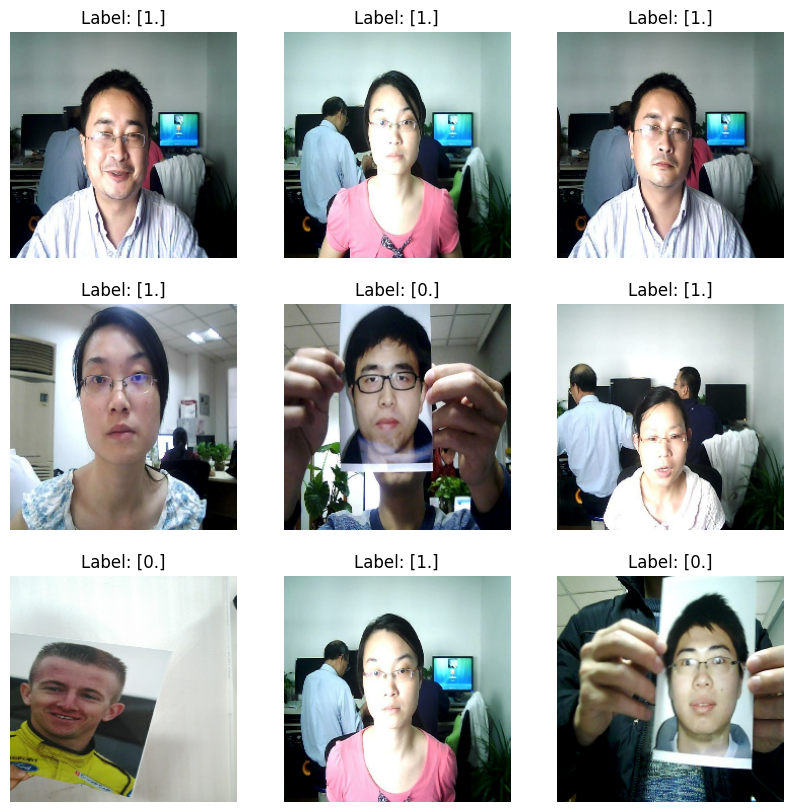

In [ ]:
from google.colab.patches import cv2_imshow

for images, labels in train_dataset.take(1):  # Take the first batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

In [ ]:
# Optimize the datasets for training
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )


validation_dataset = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )


In [ ]:
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
inputs = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.F1Score(name='f1-score')])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_156CLONE (InputLayer)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
    )

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./MobileNetV2spoof.weights.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
    )

#history = model.fit(train_dataset, epochs=25, callbacks=[early_stopping,checkpoint], validation_data=validation_dataset)
history = model.fit(train_dataset, epochs=25, validation_data=validation_dataset, callbacks=[early_stopping,checkpoint])

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9893 - f1-score: 0.5873 - loss: 0.0298 - precision: 0.9874 - recall: 0.9861
Epoch 1: val_accuracy improved from -inf to 0.98961, saving model to ./MobileNetV2spoof.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 73s 166ms/step - accuracy: 0.9893 - f1-score: 0.5874 - loss: 0.0299 - precision: 0.9874 - recall: 0.9861 - val_accuracy: 0.9896 - val_f1-score: 0.6022 - val_loss: 0.0394 - val_precision: 0.9821 - val_recall: 0.9940
Epoch 2/25
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9916 - f1-score: 0.5972 - loss: 0.0232 - precision: 0.9898 - recall: 0.9902
Epoch 2: val_accuracy did not improve from 0.98961
337/337 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.9916 - f1-score: 0.5972 - loss: 0.0232 - precision: 0.9898 - recall: 0.9902 - val_accuracy: 0.9892 - val_f1-score: 0.6034 - val_loss: 0.0333 - val_precision: 0.9854 - val_recall: 0.9896
Epoch 3/25
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9929 - f1-score: 0.60

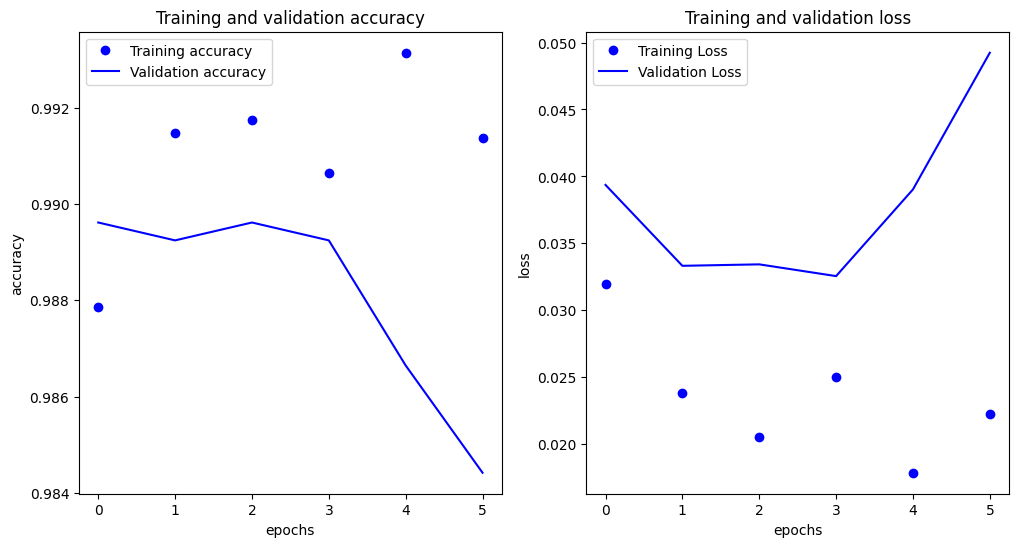

In [ ]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_loss_acc(history)

In [ ]:
model.save("/content/drive/MyDrive/Learning/Bootcamp/Bangkit/Machine_Learning/Liveness_Detection/training_model/MobileNetV2spoof[1].h5")

In [ ]:
model.save("./MobileNetV2antispoof[1].h5")

In [ ]:
from google.colab import files
files.download("./MobileNetV2antispoof[1].h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#!rm -rf ./MobileNetV2Spoof[1]

In [ ]:
#tf.saved_model.save(model, "/content/drive/MyDrive/Learning/Bootcamp/Bangkit/Machine_Learning/Liveness_Detection/training_model/MobileNetV2spoof[1]")
tf.saved_model.save(model, "./MobileNetV2spoof[1]")

In [ ]:
SAVED_SPOOF_MODEL = "./MobileNetV2spoof[1]"

In [ ]:
%%bash -s $SAVED_SPOOF_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['inputs'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_inputs:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_0'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2024-11-18 09:17:18.309522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 09:17:18.608587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 09:17:18.683142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 09:17:21.792539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1731921446.141419   22992 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/b

In [ ]:
loaded = tf.saved_model.load(SAVED_SPOOF_MODEL)

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./MobileNetV2spoof[1]/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model("./MobileNetV2Spoof[1].h5")
tflite_model = converter.convert()

AttributeError: 'str' object has no attribute 'call'

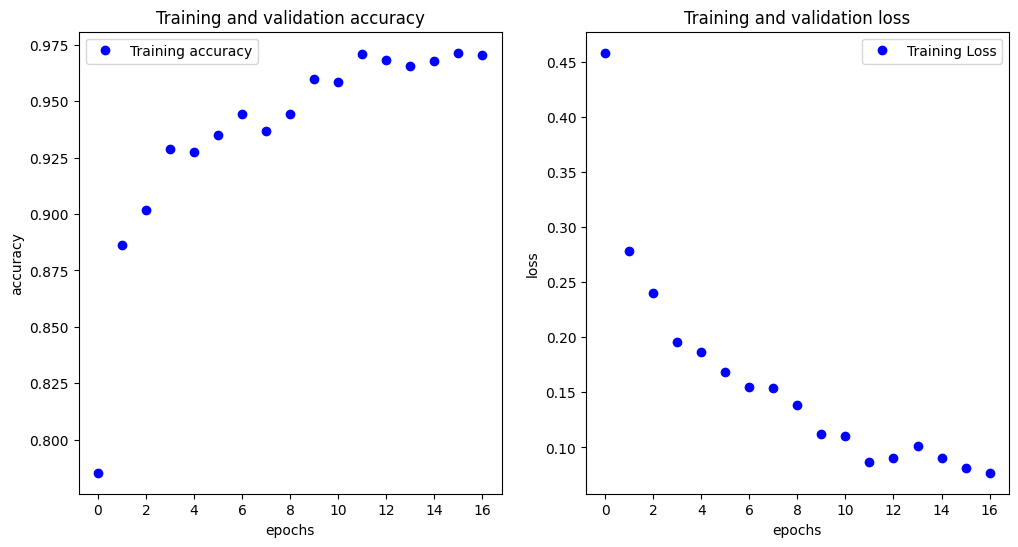

In [ ]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    #ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    #ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_loss_acc(history)

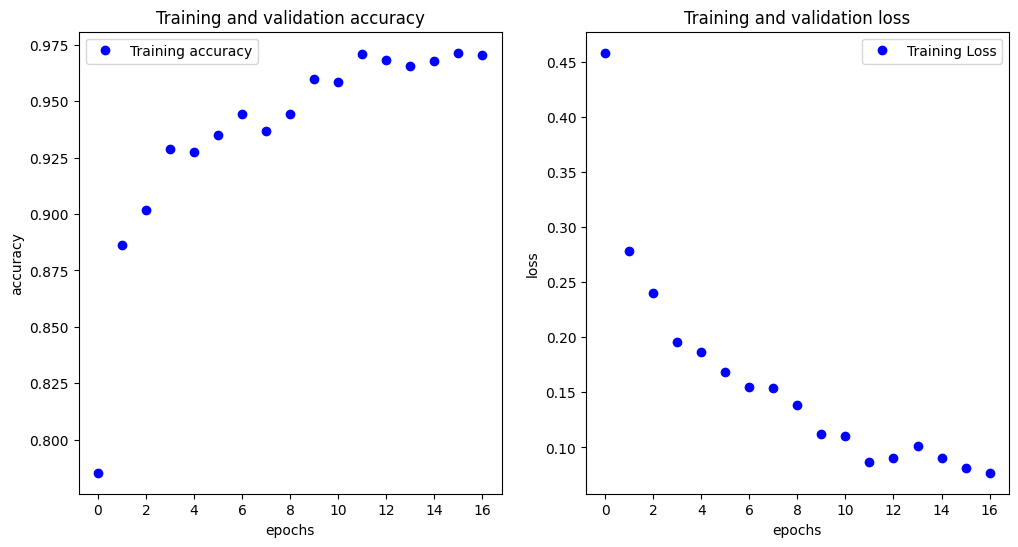

In [ ]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    #ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    #ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_loss_acc(history)

In [ ]:
loaded_model = tf.keras.models.load_model("./MobileNetV2Liveness[2].h5")

In [ ]:
loaded_model.evaluate(train_dataset)

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9836 - loss: 0.0593


[0.05539476498961449, 0.9869502186775208]

Saving IMG_20230504_223835_jpg.rf.d85ffcd78615495726867091df0def8c.jpg to IMG_20230504_223835_jpg.rf.d85ffcd78615495726867091df0def8c (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0.72477776]]
1
opened


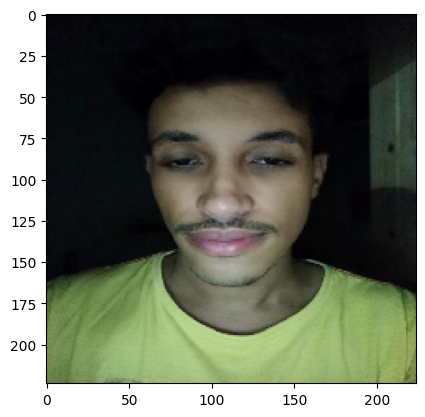

In [ ]:
from google.colab import files

image = tf.keras.preprocessing.image

uploaded = files.upload()
for fn in uploaded.keys():
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224,224))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  #x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
  images = np.vstack([x])
  #classes = model.predict(images)
  classes = loaded_model.predict(images)
  #print(fn)
  prediction = 1 if classes[0] >= 0.5 else 0
  print(classes)
  print(prediction)
  #print(classes)
  if prediction == 0:
    print('closed')
  elif prediction == 1:
    print('opened')
  else:
    print('something wrong')

In [ ]:
# Create the widget and take care of the display
from ipywidgets import widgets
from io import BytesIO
import base64
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(225, 225))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    prediction = loaded_model.predict(image, verbose=0)[0]

    with out:

        print(f'\nmodel output: {prediction}')

        prediction_index = np.argmax(prediction)

        classes = ["closed", "opened"]

        predicted_class = classes[prediction_index]

        print(f'{filename} is {predicted_class}')


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    items = change.new
    for filename, (content, metadata) in items.items(): # Loop if there is more than one file uploaded
        content_bytes = base64.b64decode(content) # Decode the content string
        file_jpgdata = BytesIO(content_bytes) # Encode the content string to bytes
        file_predict(filename, file_jpgdata, out)
    """
    items = change.new
    for item in items: # Loop if there is more than one file uploaded
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)
    """

uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7ba873395940>